# Air spring calculator

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [116]:
#constants
AREA_POS_PISTON = np.pi * (32 - 2*2.05) ** 2 / 4
AREA_NEG_PISTON = AREA_POS_PISTON - np.pi * 10 ** 2 / 4
LEFT_LEG_AREA = np.pi * 32 ** 2 / 4 - np.pi * 10 ** 2 / 4
RIGHT_LEG_AREA = np.pi * 32 ** 2 / 4 - np.pi * 12 ** 2 / 4
LEG_AREA = np.pi * 38 ** 2 / 4 

NEG_FILL_COEFF = 0.9

SAG = 110 * 0.25
SAG_FORCE = 182.53 #N; based on ref fork with 63psi

In [151]:
# stock condition with 110mm of travel
def get_spring_force(x, h_pos_ini = 170, h_neg_ini = 60, sag=SAG):
#     p_ini = 63 * 0.00689475728 #N/mm2
    #TODO: make this function accept sag, not pressure
    
    v_pos_ini = h_pos_ini * AREA_POS_PISTON
    v_pos_sag = v_pos_ini - sag * AREA_POS_PISTON
    v_neg_ini = h_neg_ini * AREA_NEG_PISTON * NEG_FILL_COEFF
    v_neg_sag = v_neg_ini + sag * AREA_NEG_PISTON
    p_ini = (SAG_FORCE - get_lowers_force(sag) - get_damper_spring_force(sag)) / (AREA_POS_PISTON * v_pos_ini / v_pos_sag - AREA_NEG_PISTON * v_neg_ini / v_neg_sag)
#     print(p_ini / 0.00689475728)
    v_pos = v_pos_ini - x * AREA_POS_PISTON
    p_pos = p_ini * v_pos_ini / v_pos
    f_pos = p_pos * AREA_POS_PISTON
    
    v_neg = v_neg_ini + x * AREA_NEG_PISTON
    p_neg = p_ini * v_neg_ini / v_neg
#     print(f"pressure in negative chamber {p_neg}MPa")
    f_neg = - p_neg * AREA_NEG_PISTON
#     print(f_pos)
#     print(f_neg)
    SAG_FORCE == f_pos + f_neg
    return f_pos + f_neg

def get_lowers_force(x):
    """returns the force from compressing the air in both lowers;
    assumed the seal heads are at the stancions"""
    
    p_ini = 0.101325 # equal to 1 atm
    
    v_ini_left = 110 * (LEG_AREA - np.pi * 10 ** 2 / 4) + (290 - 110) * (LEG_AREA - np.pi * 32 ** 2 / 4)
    v_left = v_ini_left - x * LEFT_LEG_AREA
    p_left = p_ini * v_ini_left / v_left - p_ini # relative pressure to 1atm
    f_left = p_left * LEFT_LEG_AREA
#     print(f"pressure in left lower: {p_ini+p_left}MPa")
    
    v_ini_right = 110 * (LEG_AREA - np.pi * 12 ** 2 / 4) + (290 - 110) * (LEG_AREA - np.pi * 32 ** 2 / 4)
    v_right = v_ini_right - x * RIGHT_LEG_AREA
    p_right = p_ini * v_ini_right / v_right - p_ini # relative pressure to 1atm
    f_right = p_right * RIGHT_LEG_AREA
    
    return f_left + f_right


def get_damper_spring_force(x):
    """retuns the force from compressing the air in the upper part of the damper
    """
    p_ini = 0.101325 # equal to 1 atm
    
    v_ini = 0.8 * 85 * (np.pi * 28 ** 2 / 4) #fill coeficent of 0.8; 85mm air gap at the top
    v_damp = v_ini - x * np.pi * 12 ** 2 / 4
    p_damp = p_ini * v_ini / v_damp - p_ini # relative pressure to 1atm
    f_damp = p_damp * np.pi * 12 ** 2 / 4
    return f_damp


def get_total_force(x, h_pos_ini = 170, h_neg_ini = 60, sag=SAG):
    return get_spring_force(x, h_pos_ini, h_neg_ini, sag) + get_lowers_force(x) + get_damper_spring_force(x)

def get_spring_rate(x, h_pos_ini = 170, h_neg_ini = 60, sag=SAG):
    STEP = 1
    return (get_total_force(x + 0.5*STEP, h_pos_ini, h_neg_ini, sag) - get_total_force(x - 0.5*STEP, h_pos_ini, h_neg_ini, sag)) / STEP

In [98]:
#unit testing
assert(abs(AREA_POS_PISTON - AREA_NEG_PISTON == np.pi * 10 ** 2 / 4) < 0.01)
assert(abs(get_spring_force(0) == 63 * 0.00689475728 * np.pi * 5 **2) < 0.01)

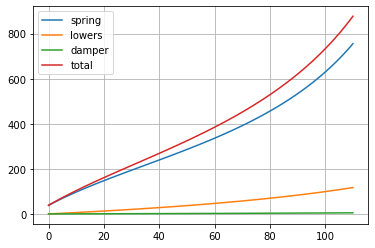

In [111]:
x = np.linspace(0, 110, 110)
plt.plot(x, get_spring_force(x), label="spring")
plt.plot(x, get_lowers_force(x), label="lowers")
plt.plot(x, get_damper_spring_force(x), label="damper")
plt.plot(x, get_total_force(x), label="total")

plt.legend()
plt.grid()
plt.show()

In [82]:
get_lowers_force(110)

pressure in left lower: 0.1858789655172414MPa


117.01815311665553

In [87]:
get_spring_force(110, h_neg_ini = 60+47)

pressure in negative chamber 0.24232314092347726MPa


770.1004174821151

In [85]:
# 63 * 0.00689475728*47/(47+110) #doesn't include reduction of negative chamber due to fill ins

pressure in left lower at bottom out: 0.1858789655172414MPa
pressure in negative chamber at bottom out, stock build: 0.14302679742174107MPa
pressure in negative chamber at bottom out, max neg: 0.24232314092347726MPa
If modification of the negative chamber is made, the pressure in the negative air chamber will always be higher than the lowers pressure. It is possible to use one way U-cup seal.

In [6]:
110*0.25

27.5

In [104]:
sag_force = get_total_force(110*0.25)
sag_force

182.53256618540433

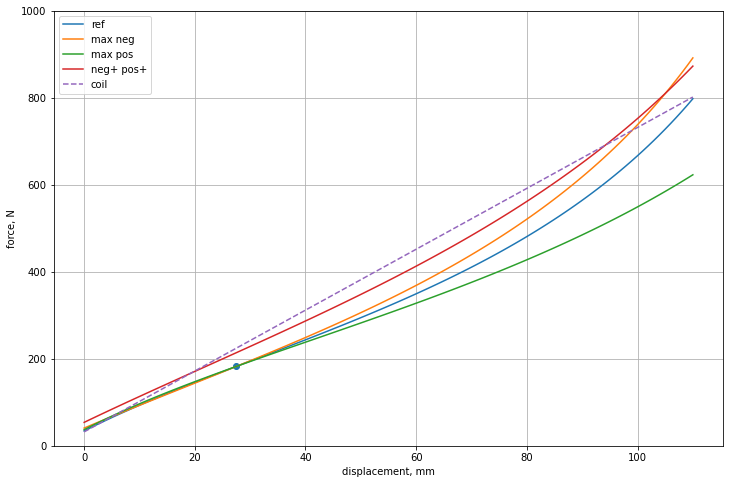

In [163]:
x = np.linspace(0, 110, 110)

plt.figure(figsize=(12,8))
plt.plot(x, get_total_force(x),  label="ref")
plt.plot(x, get_total_force(x, h_neg_ini = 60+47, sag=0.25*110), label="max neg")
plt.plot(x, get_total_force(x, h_pos_ini = 170+47), label="max pos")
plt.plot(x, get_total_force(x, h_neg_ini = 60+60, h_pos_ini = 170+30, sag=0.2*110), label="neg+ pos+")
plt.plot(x, 32 + 7 * x, "--", label="coil")



plt.scatter(SAG, SAG_FORCE)

plt.xlabel("displacement, mm")
plt.ylabel("force, N")

plt.ylim(0, 1000)
plt.grid()
plt.legend()
plt.show()

In [118]:
SAG_FORCE

182.53

In [37]:
get_spring_force(0) / 6

5.685990548738052

A coil spring with stiffness 6N/mm, will require 5.68 mm of travel to equalize with compression force on the rod.

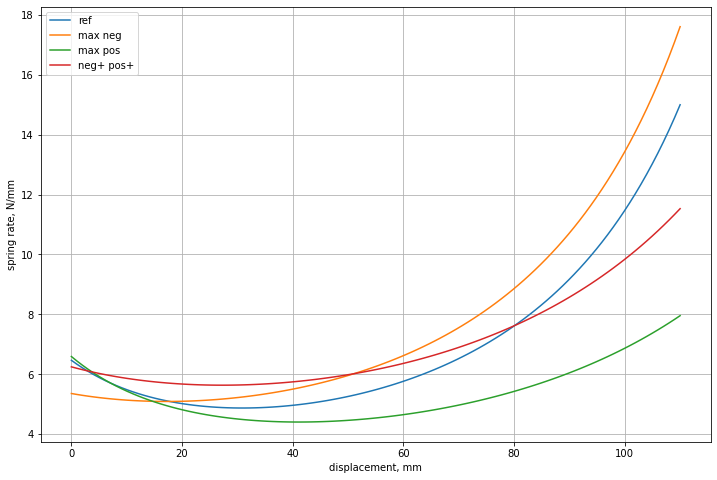

In [152]:
x = np.linspace(0, 110, 110)

plt.figure(figsize=(12,8))
plt.plot(x, get_spring_rate(x),  label="ref")
plt.plot(x, get_spring_rate(x, h_neg_ini = 60+47, sag=0.25*110), label="max neg")
plt.plot(x, get_spring_rate(x, h_pos_ini = 170+47), label="max pos")
plt.plot(x, get_spring_rate(x, h_neg_ini = 60+50, h_pos_ini = 170+40, sag=0.20*110), label="neg+ pos+")
plt.xlabel("displacement, mm")
plt.ylabel("spring rate, N/mm")

# plt.ylim(0, 700)
plt.grid()
plt.legend()
plt.show()